In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.stochastic.solver import get_schedule
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [2]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)
print(ALL_MODELS_DICT.keys())

dict_keys(['DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.01_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.05_invsqrt', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_betamin_0.05_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_beta

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 6

MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_N_1000_bottleneck_32_firstc_10_phi'

In [4]:
config = config_from_id(MODEL_ID)

In [5]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config, also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [6]:
tmin = diffuser.diffmodel.sde.tmin
tmax = diffuser.diffmodel.sde.tmax
tmin, tmax

(0.0001, 1.0)

In [7]:
NOISE_LEVEL = 0.1

In [8]:
closest_timestep = diffuser.diffmodel.sde.get_closest_timestep(torch.tensor([NOISE_LEVEL]))

In [9]:
T = closest_timestep.item()
T

0.02699493244290352

In [10]:
data_loader = diffuser.test_dataloader

In [11]:
batch = next(iter(data_loader))

In [12]:
batch = batch.unsqueeze(1).to(device)

In [13]:
NUM_SAMPLES = 1000

In [14]:
rphi = torch.zeros(1,2).to(device)
phi = diffuser.diffmodel.ps.unscale_phi(rphi)

In [15]:
ps_phi = diffuser.diffmodel.ps(phi)

sq_ps_phi = torch.sqrt(ps_phi)

In [16]:
forward_samples_pair = []
for k in range(NUM_SAMPLES//len(batch)):
    timesteps = T*torch.ones(len(batch), device=device)
    X_t, _, _ = diffuser.diffmodel.sde.sampling(batch, timesteps, sq_ps_phi)
    forward_samples_pair.append((batch.cpu(), X_t.clone().detach().cpu()))

In [17]:
schedule = get_schedule('power_law', t_min = tmin, t_max = T, power = 2, n_iter = 100)
backward_samples_pair = []
for k in range(NUM_SAMPLES//len(batch)):
    timesteps = T*torch.ones(len(batch), device=device)
    X_t, _, _ = diffuser.diffmodel.sde.sampling(batch, timesteps, sq_ps_phi)
    #schedule = get_schedule('power_law', t_min = tmin, t_max = T, power = 2, n_iter = 100)
    #X_0_hat = diffuser.diffmodel.generate_image(X_t.shape[0], sample = X_t, schedule = schedule, phi = phi.repeat(len(X_t),1), verbose = True)
    schedule = get_schedule('power_law', t_min = diffuser.diffmodel.sde.tmin, t_max = T, n_iter = 100, power = 1.5)
    X_0_hat = diffuser.diffmodel.generate_image(X_t.shape[0], sample = X_t, schedule = schedule, verbose=False, phi = phi.repeat(len(X_t),1))
    backward_samples_pair.append((X_0_hat.clone().detach().cpu(), X_t.clone().detach().cpu()))
    break

Text(0.5, 1.0, 'X_t_2')

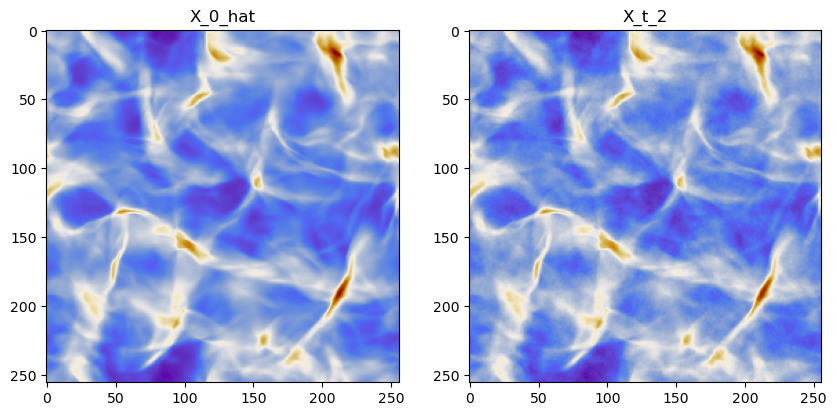

In [18]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(X_0_hat[0].squeeze().cpu(), cmap = 'cmb')
ax[0].set_title('X_0_hat')
ax[1].imshow(X_t[0].squeeze().cpu(), cmap = 'cmb')
ax[1].set_title('X_t_2')

In [25]:
X_0_1, X_t_1 = torch.cat([x[0] for x in forward_samples_pair]), torch.cat([x[1] for x in forward_samples_pair])
X_0_hat, X_t_2 = torch.cat([x[0] for x in backward_samples_pair]), torch.cat([x[1] for x in backward_samples_pair])

In [26]:
mean_X_0 = []
mean_X_t = []
mean_X_0_hat = []

var_X_0 = []
var_X_t = []
var_X_0_hat = []

covar_X_0_X_t = []
covar_X_0_hat_X_t = []

for i in range(1, len(X_0_1)):
    mean_X_0.append(X_0_1[:i].mean())
    mean_X_t.append(X_t_1[:i].mean())
    mean_X_0_hat.append(X_0_hat[:i].mean())

    var_X_0.append(X_0_1[:i].var())
    var_X_t.append(X_t_1[:i].var())
    var_X_0_hat.append(X_0_hat[:i].var())

    covar_X_0_X_t.append(torch.mean((X_0_1[:i])*(X_t_1[:i])))
    covar_X_0_hat_X_t.append(torch.mean((X_0_hat[:i])*(X_t_2[:i])))

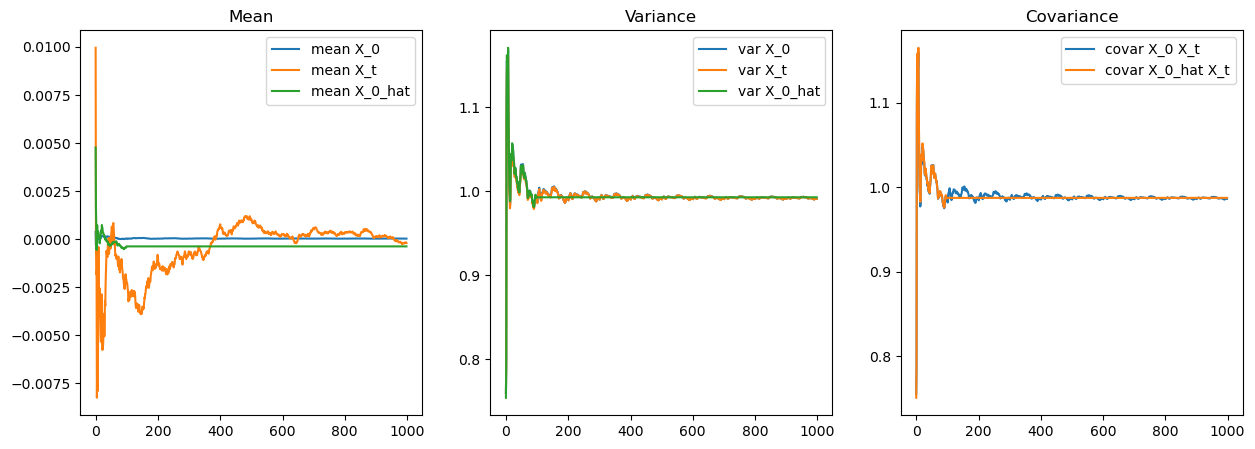

In [27]:
## Plot all of these in three subplots

fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(mean_X_0, label = 'mean X_0')
ax[0].plot(mean_X_t, label = 'mean X_t')
ax[0].plot(mean_X_0_hat, label = 'mean X_0_hat')
ax[0].set_title('Mean')
ax[0].legend()

ax[1].plot(var_X_0, label = 'var X_0')
ax[1].plot(var_X_t, label = 'var X_t')
ax[1].plot(var_X_0_hat, label = 'var X_0_hat')
ax[1].legend()
ax[1].set_title('Variance')

ax[2].plot(covar_X_0_X_t, label = 'covar X_0 X_t')
ax[2].plot(covar_X_0_hat_X_t, label = 'covar X_0_hat X_t')
ax[2].set_title('Covariance')
ax[2].legend()


In [52]:
## Compute more complicated statistics of the joint distributions (X_0, X_t) and (X_0_hat, X_t) to check if they are the same

## Compute covariance matriced of psi(X_0) and psi(X_t) for the two distributions with psi : R^(HW)-> R^d

def compute_covariance_matrix(X_0, X_t, psi):
    """
    X_0 : tensor of shape (N, C, H, W)
    X_t : tensor of shape (N, C, H, W)
    psi : function that takes a tensor of shape (N,C, H, W) and returns a tensor of shape (N, d)
    """
    N = X_0.shape[0]
    return torch.einsum('ij,ik->jk', psi(X_0).reshape(N,-1), psi(X_t).reshape(N,-1))/N - torch.einsum('ij->j', psi(X_0).reshape(N,-1))/N*torch.einsum('ik->k', psi(X_t).reshape(N,-1))/N

In [54]:
import pywph as pw

In [90]:
M, N = 256, 256
J = 3
L = 3
dn = 0

In [91]:
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)

In [92]:
psi = lambda x : wph_op(x)

In [93]:
cov1 = compute_covariance_matrix(X_0_1, X_t_1, psi)
cov2 = compute_covariance_matrix(X_0_hat, X_t_2, psi)

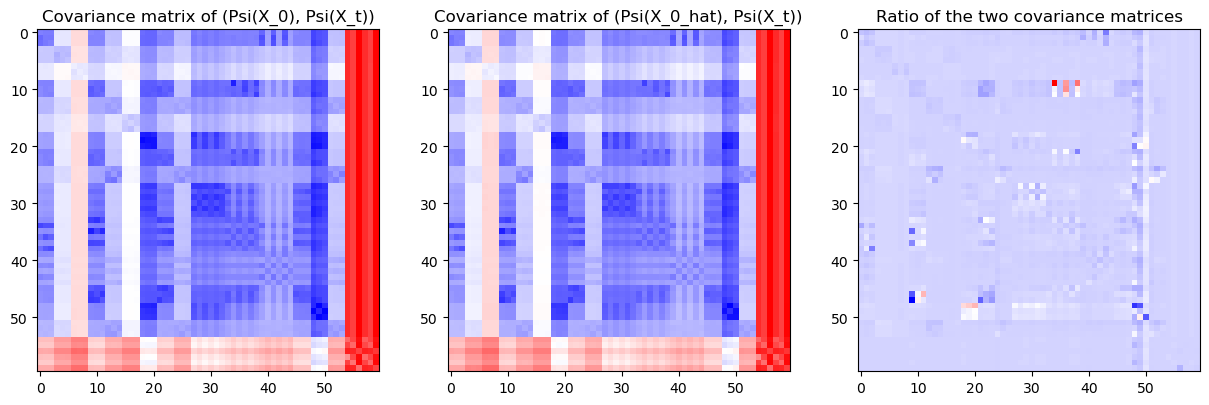

In [94]:
## Plot the two covariance matrices

fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(torch.log(cov1.cpu().abs()), cmap = 'bwr')
ax[0].set_title('Covariance matrix of (Psi(X_0), Psi(X_t))')
ax[1].imshow(torch.log(cov2.cpu().abs()), cmap = 'bwr')
ax[1].set_title('Covariance matrix of (Psi(X_0_hat), Psi(X_t))')
ax[2].imshow(torch.log(cov2.cpu().abs()/cov1.cpu().abs()), cmap = 'bwr')
ax[2].set_title('Ratio of the two covariance matrices')
plt.show()

In [95]:
## Find the argmax of torch.log(cov2.cpu().abs()/cov1.cpu().abs()), this is a matrix of shape (d,d) 

torch.max(torch.log(cov2.cpu().abs()/cov1.cpu().abs()))


tensor(1.0556)